## Fuente de datos
### MT560
* Recopilación de diferentes corpus en inglés a un idioma de destino.
* La recopilación de este corpus tiene las siguientes fuentes para diferentes idiomas, el resto de información puede ser encontrado en: [MTData.recipes](https://github.com/thammegowda/016-many-eng-v2/blob/2bf3e75ce/data/mtdata.recipes.yml)

| Fuentes |
|-------|
| JW300 |
| OPUS100  |
| OPUSGnome |
| OPUSUbuntu |
| OPUS-bibleuedin |
| OPUS-wikimedia |

## Construcción del Corpus
### Variantes del quechua

| ISO 639-3 | Nombre                                  | País      | Oraciones | Tokens    |
|-----------|-----------------------------------------|-----------|-----------|-----------|
| QUZ       | Cusco Quechua                           | Perú      | 127,408   | 1,649,454 |
| QUY       | Ayacucho Quechua                        | Perú      | 113,702   | 1,402,781 |
| QVI       | Imbabura Highland Quichua               | Ecuador   | 50,527    | 672,711   |
| QUG       | Chimborazo Highland Quichua             | Ecuador   | 20,272    | 247,947   |
| QUW       | Tena Lowland Quichua                    | Ecuador   | 15,674    | 292,905   |

### Otras lenguas indígenas

| ISO 639-3 | Nombre              | País             | Oraciones | Tokens    |
|-----------|---------------------|------------------|-----------|-----------|
| YUA       | Yucateco            | México           | 168,299   | 3,524,830 |
| GUG       | Paraguayan Guaraní  | Paraguay         | 143,391   | 2,151,216 |
| TZO       | Tzotzil             | México           | 140,124   | 2,993,791 |
| AYM       | Aymara              | Bolivia/Perú     | 138,760   | 1,939,507 |
| MRI       | Maori               | Nueva Zelanda    | 62,963    | 2,151,493 |


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
basePath = "/content/drive/MyDrive/corpus_quechua"

## MT560

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

basePath = "/content/drive/MyDrive/corpus_quechua"
df = pd.read_csv(f"{basePath}/filtered_corpus.csv")

import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-záéíóúüñ' ]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["Sentence"] = df["Sentence"].apply(clean_text)

lang_names = {
    "quz": "Cusco\nQuechua",
    "quy": "Ayacucho\nQuechua",
    "qvi": "Imbabura Highland\nQuichua",
    "qug": "Chimborazo Highland\nQuichua",
    "quw": "Tena Lowland\nQuichua",
    "yua": "Yucateco",
    "gug": "Paraguayan\nGuaraní",
    "tzo": "Tzotzil",
    "aym": "Aymara",
    "mri": "Maori"
}

quechua_langs = {"quz", "quy", "qvi", "qug", "quw"}
other_langs = {"yua", "gug", "tzo", "aym", "mri"}

df_quechua = df[df['ISO'].isin(quechua_langs)].copy()
df_other = df[df['ISO'].isin(other_langs)].copy()

counts = df["ISO"].value_counts()
quechua_counts = counts[counts.index.isin(quechua_langs)]
other_counts = counts[counts.index.isin(other_langs)]

quechua_counts.index = quechua_counts.index.map(lang_names)
other_counts.index = other_counts.index.map(lang_names)

quechua_counts = quechua_counts.sort_values(ascending=False)
other_counts = other_counts.sort_values(ascending=False)

def plot_with_labels(data, title, color):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(data.index, data.values, color=color)
    plt.title(title)
    plt.xlabel("Idioma")
    plt.ylabel("Oraciones")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + yval*0.01, f"{yval:,}",
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

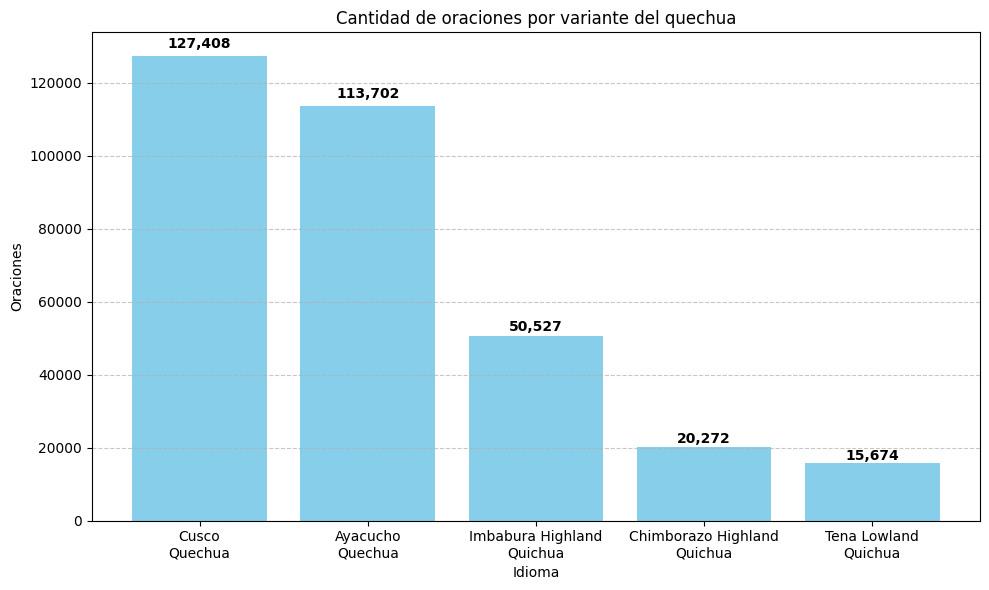

In [ ]:
plot_with_labels(quechua_counts, "Cantidad de oraciones por variante del quechua", "skyblue")

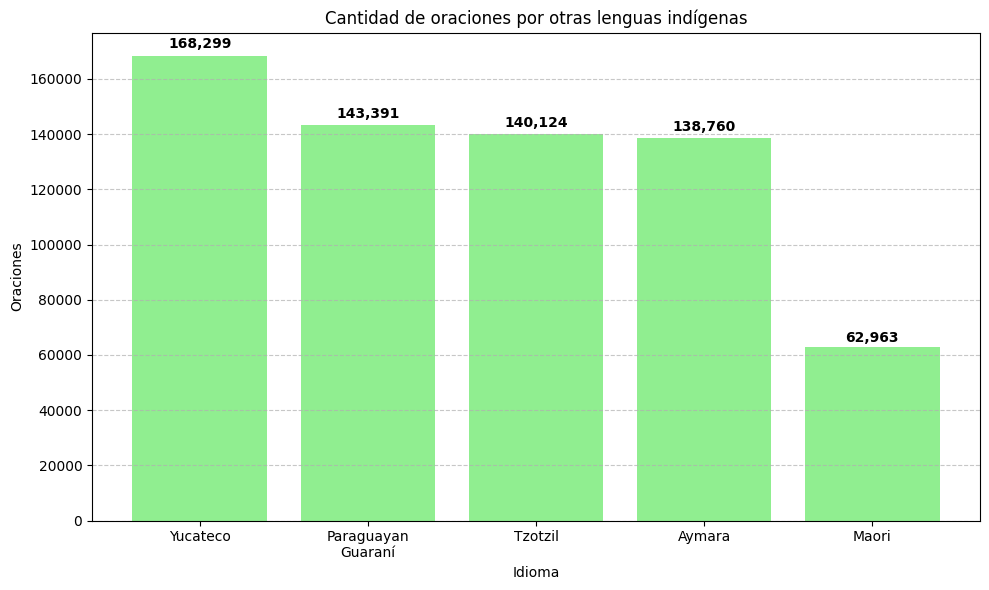

In [ ]:
plot_with_labels(other_counts, "Cantidad de oraciones por otras lenguas indígenas", "lightgreen")

## One-Hot Encoding


In [ ]:
result_df = pd.DataFrame()
result_df["Sentence"] = df_quechua["Sentence"]

# Filtrado 0,1
for lang in quechua_langs:
    result_df[lang] = (df["ISO"] == lang).astype(int)

result_df.to_csv((f"{basePath}/quechua_labeled_corpus.csv"), index=False, encoding="utf-8")

In [ ]:
df_quechua_labeled = pd.read_csv(f"{basePath}/quechua_labeled_corpus.csv")

In [ ]:
df_quechua_labeled.head()

,Sentence,quy,quw,qvi,qug,quz
0,allinta uyariychis,0,0,0,0,1
1,inculquen en sus hijos valores que los protejan,0,0,0,0,1
2,llaqtaykin llaqtay kanqa diosniykin diosniy kanqa,0,0,0,0,1
3,mamay ratollachu kutimunki,0,0,0,0,1
4,paqarisnintaq moisesqa llaqtata nirqan anchata...,0,0,0,0,1


In [ ]:
language_columns = ["quz", "quy", "qvi", "qug", "quw"]
df_quechua_labeled[language_columns].sum()

,0
quz,127408
quy,113702
qvi,50527
qug,20272
quw,15674


In [ ]:
df_quechua_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327583 entries, 0 to 327582
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Sentence  326573 non-null  object
 1   quy       327583 non-null  int64 
 2   quw       327583 non-null  int64 
 3   qvi       327583 non-null  int64 
 4   qug       327583 non-null  int64 
 5   quz       327583 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 15.0+ MB


## Regresión logística univariada

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

import nltk
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df_quechua_cusco = df_quechua_labeled.filter(['Sentence','quz'], axis=1)

In [ ]:
df_quechua_cusco.head()

,Sentence,quz
0,allinta uyariychis,1
1,inculquen en sus hijos valores que los protejan,1
2,llaqtaykin llaqtay kanqa diosniykin diosniy kanqa,1
3,mamay ratollachu kutimunki,1
4,paqarisnintaq moisesqa llaqtata nirqan anchata...,1


In [ ]:
df_quechua_cusco.dropna(inplace=True)
change_labels = lambda x: 1 if x==0 else 0
df_quechua_cusco['quz'] = df_quechua_cusco['quz'].apply(change_labels)
df_quechua_cusco.head()

,Sentence,quz
0,allinta uyariychis,0
1,inculquen en sus hijos valores que los protejan,0
2,llaqtaykin llaqtay kanqa diosniykin diosniy kanqa,0
3,mamay ratollachu kutimunki,0
4,paqarisnintaq moisesqa llaqtata nirqan anchata...,0


In [ ]:
tokenize = lambda x: word_tokenize(x)

ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]

lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

In [ ]:
print('Processing : [=', end='')
df_quechua_cusco['Sentence'] = df_quechua_cusco['Sentence'].apply(tokenize)
print('=', end='')
df_quechua_cusco['Sentence'] = df_quechua_cusco['Sentence'].apply(stem)
print('=', end='')
df_quechua_cusco['Sentence'] = df_quechua_cusco['Sentence'].apply(leammtizer)
print('=', end='')
df_quechua_cusco['Sentence'] = df_quechua_cusco['Sentence'].apply(lambda x: ' '.join(x))
print('] : Completed', end='')
df_quechua_cusco.head()

Processing : [====] : Completed

,Sentence,quz
0,allinta uyariychi,0
1,inculquen en su hijo valor que lo protejan,0
2,llaqtaykin llaqtay kanqa diosniykin diosniy kanqa,0
3,mamay ratollachu kutimunki,0
4,paqarisnintaq moisesqa llaqtata nirqan anchata...,0


In [ ]:
max_words = 1000
cv = CountVectorizer(max_features=max_words)
sparse_matrix = cv.fit_transform(df_quechua_cusco['Sentence']).toarray()

In [ ]:
sparse_matrix.shape

(326573, 1000)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(df_quechua_cusco['quz']))

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(1000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)

In [ ]:
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()

In [ ]:
epochs = 30
model.train()
loss_values = []
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss_values.append(loss.item())
    pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
    acc = pred * 100.0 / len(x_train)
    print('Epoch: {}, Loss: {}, Accuracy: {}%'.format(epoch+1, loss.item(), acc.numpy()))
    loss.backward()
    optimizer.step()

Epoch: 1, Loss: 0.7376267313957214, Accuracy: 38.87902069091797%
Epoch: 2, Loss: 0.7066396474838257, Accuracy: 38.95128631591797%
Epoch: 3, Loss: 0.6720123291015625, Accuracy: 58.6165771484375%
Epoch: 4, Loss: 0.6279202699661255, Accuracy: 81.5824203491211%
Epoch: 5, Loss: 0.5770732164382935, Accuracy: 83.40744018554688%
Epoch: 6, Loss: 0.5226839780807495, Accuracy: 84.2109375%
Epoch: 7, Loss: 0.46797922253608704, Accuracy: 85.34391784667969%
Epoch: 8, Loss: 0.41528505086898804, Accuracy: 87.16239929199219%
Epoch: 9, Loss: 0.3662694990634918, Accuracy: 88.64732360839844%
Epoch: 10, Loss: 0.3221728205680847, Accuracy: 89.71620178222656%
Epoch: 11, Loss: 0.2837059497833252, Accuracy: 90.36455535888672%
Epoch: 12, Loss: 0.2511293590068817, Accuracy: 90.66464233398438%
Epoch: 13, Loss: 0.22397612035274506, Accuracy: 90.93370056152344%
Epoch: 14, Loss: 0.2022765427827835, Accuracy: 91.21255493164062%
Epoch: 15, Loss: 0.18682162463665009, Accuracy: 91.35340881347656%
Epoch: 16, Loss: 0.17693

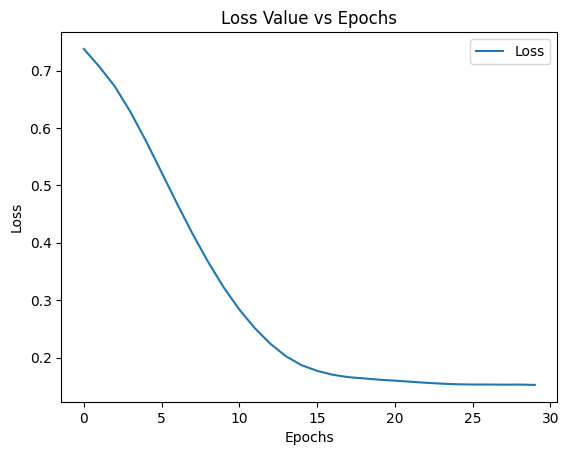

In [ ]:
plt.plot(loss_values)
plt.title('Loss Value vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.show()

## Red Neuronal Profunda

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
df_quechua_labeled = pd.read_csv(f"{basePath}/quechua_labeled_corpus.csv")

In [ ]:
df_quechua_labeled.isna().sum()

,0
Sentence,1010
quy,0
quw,0
qvi,0
qug,0
quz,0


In [ ]:
df_quechua_labeled.head()

,Sentence,quy,quw,qvi,qug,quz
0,allinta uyariychis,0,0,0,0,1
1,inculquen en sus hijos valores que los protejan,0,0,0,0,1
2,llaqtaykin llaqtay kanqa diosniykin diosniy kanqa,0,0,0,0,1
3,mamay ratollachu kutimunki,0,0,0,0,1
4,paqarisnintaq moisesqa llaqtata nirqan anchata...,0,0,0,0,1


In [ ]:
df_quechua_labeled = df_quechua_labeled.dropna(subset=["Sentence"])

In [ ]:
max_words = 1000
cv = CountVectorizer(max_features=max_words)
X = cv.fit_transform(df_quechua_labeled["Sentence"]).toarray()

In [ ]:
y = df_quechua_labeled[["quy", "quw", "qvi", "qug", "quz"]].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       128,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,709 (534.02 KB)

 Trainable params: 136,709 (534.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8357 - loss: 0.3867 - val_accuracy: 0.8894 - val_loss: 0.2181
Epoch 2/10
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8937 - loss: 0.2094 - val_accuracy: 0.8921 - val_loss: 0.2098
Epoch 3/10
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8995 - loss: 0.1998 - val_accuracy: 0.8932 - val_loss: 0.2089
Epoch 4/10
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9029 - loss: 0.1942 - val_accuracy: 0.8918 - val_loss: 0.2108
Epoch 5/10
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9056 - loss: 0.1897 - val_accuracy: 0.8935 - val_loss: 0.2112
Epoch 6/10
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9100 - loss: 0.1819 - val_accuracy: 0.8924 - val_loss: 0.2126
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8928 - loss: 0.2090

🎯 Precisión en test: 0.8932


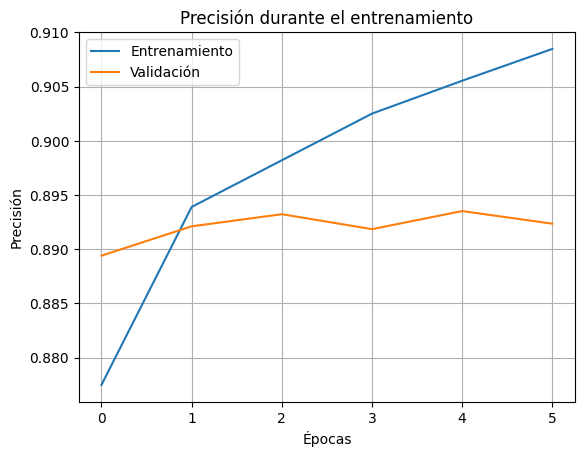

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(max_words)),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=128,
    callbacks=[early_stop]
)

loss, acc = model.evaluate(X_test, y_test)
print(f"\n🎯 Precisión en test: {acc:.4f}")

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Precisión durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.show()

2042/2042 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


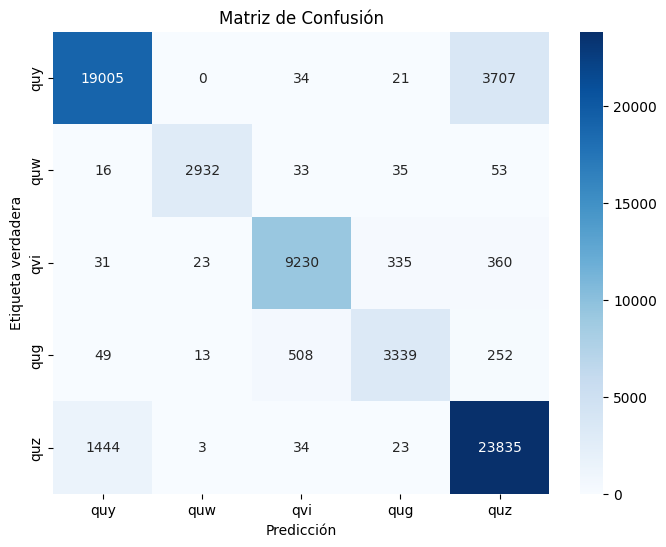


Reporte de clasificación:
              precision    recall  f1-score   support

         quy       0.93      0.83      0.88     22767
         quw       0.99      0.96      0.97      3069
         qvi       0.94      0.92      0.93      9979
         qug       0.89      0.80      0.84      4161
         quz       0.85      0.94      0.89     25339

    accuracy                           0.89     65315
   macro avg       0.92      0.89      0.90     65315
weighted avg       0.90      0.89      0.89     65315



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["quy", "quw", "qvi", "qug", "quz"],
            yticklabels=["quy", "quw", "qvi", "qug", "quz"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.title("Matriz de Confusión")
plt.show()

print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=["quy", "quw", "qvi", "qug", "quz"]))